In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

In [29]:
from core.utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(0)

MAX_GAIN = 200

# Read and sanitize the data
# df = pd.read_excel("../data/t00/UG_HH_NEW_continuous_no200.xls")

# Read and sanitize the data
df = pd.read_csv("../data/t00/data_t00.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()


# display(df.head())
# df.hist()
df.head()

,cc_beta,cc_criterion,cc_false_alarm_avg_click_delay,cc_false_alarm_rate,cc_false_alarms,cc_hit_avg_click_delay,cc_hit_rate,cc_hits,cc_sensitivity,cpc_expected_value,...,ras_q8,ras_q9,ras_time_spent,resp_time_spent,risk_expected_value,risk_q1,risk_q2,risk_q3,risk_q4,risk_time_spent
0,0.786247,-0.146466,271.0,0.25,1,290.00,0.833333,5,1.641911,9.5323,...,-1,-1,115,11,3.0125,1.05,1.50,3.50,6.00,52
1,0.744767,1.266672,0.0,0.00,0,0.00,0.000000,0,-0.232645,9.5323,...,-2,-2,227,12,1.8200,1.04,1.20,2.00,3.04,62
2,1.766303,0.359811,0.0,0.00,0,362.75,0.666667,4,1.581077,10.6715,...,1,2,95,21,1.8200,1.04,1.20,2.00,3.04,39
3,0.626283,-0.483711,205.0,0.50,2,232.00,0.833333,5,0.967422,10.2117,...,2,2,153,8,4.6450,1.09,1.99,5.50,10.00,101
4,1.766303,0.790538,0.0,0.00,0,420.00,0.333333,2,0.719622,8.6673,...,-2,3,107,9,2.0350,1.02,1.60,1.53,3.99,18


In [30]:
from sklearn.linear_model import LinearRegression
from core.utils.preprocessing import df_to_xy

x, y = df_to_xy(df, drop_columns=["prop", "other_resp", "other_prop", "time_spent_prop"])
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)



In [31]:
from core.utils.data_augmentation import DACombine

In [32]:
from core.models.deep import loss_tf, gain_tf, KerasModel

**Metrics**

In [33]:
from core.models.metrics import avg_gain_ratio, gain_mean, avg_loss_ratio

**AcceptanceModel**

In [34]:
from core.models import AcceptanceModel

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


gain_mean:  20.15
gain ratio:  0.35532382237645393


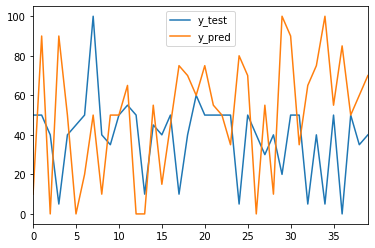

In [35]:
from sklearn.ensemble.bagging import BaggingRegressor, BaggingClassifier, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import NuSVC, SVC, LinearSVC, LinearSVR, SVR, NuSVR

#LinearSVR, zero_one=True: 87
#SVR, zero_one=True: 70

model = AcceptanceModel(LinearSVR(loss='epsilon_insensitive', ), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yTrain_[yTrain_ < 50] = 50

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gain_mean:  2.5
gain ratio:  0.025


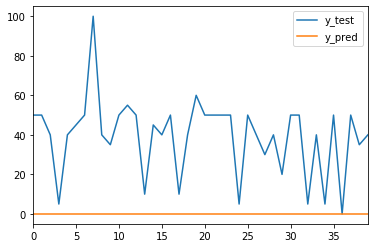

In [36]:
model = AcceptanceModel(SVR(gamma="auto"), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


gain_mean:  5.1
gain ratio:  0.06157894736842105


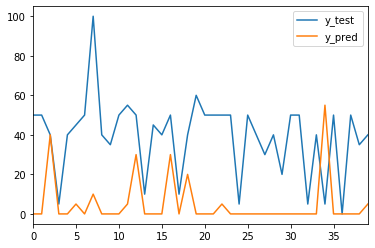

In [37]:
model = AcceptanceModel(LinearSVC(loss='epsilon_insensitive'), step=5, zero_one=True)
#model = AcceptanceModel(KerasModel(epochs=300), zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gain_mean:  3.25
gain ratio:  0.04


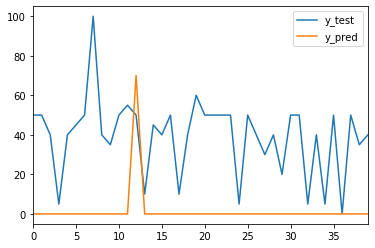

In [11]:
model = AcceptanceModel(PassiveAggressiveClassifier(), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


gain_mean:  8.25
gain ratio:  0.11260442773600668


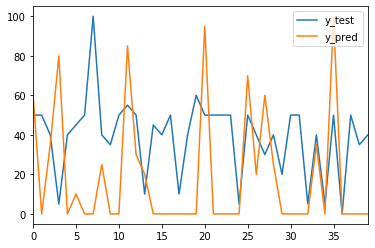

In [12]:
model = AcceptanceModel(LogisticRegression(solver='lbfgs'), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
da = DACombine()
xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=15, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

gain_mean:  16.5
gain ratio:  0.2423651878092668


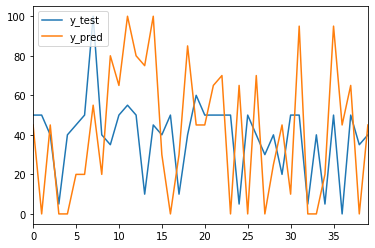

In [13]:
model = AcceptanceModel(LinearRegression(), step=5, zero_one=True)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=True, distance=5, retarget=True, combine=True)
model.fit(xTrain_, yTrain_)
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

gain_mean:  46.25
gain ratio:  0.772807583498373


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


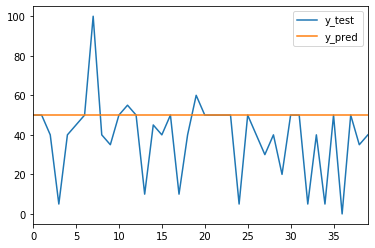

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
model.fit(xTrain_, yTrain_.ravel())

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [15]:
from core.utils.data_augmentation import DASampling

gxTrain, gyTrain = DASampling().generate_data(xTrain, yTrain, size=10000)

gain_mean:  46.25
gain ratio:  0.772807583498373


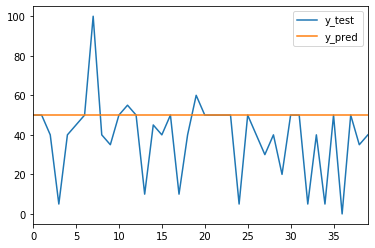

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#model = MLPClassifier(hidden_layer_sizes=(1000,), )
model = PassiveAggressiveClassifier(max_iter=1000, tol=1e-4)
model.fit(gxTrain, gyTrain.ravel())

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

gain_mean:  45.0
gain ratio:  0.7519742501650397


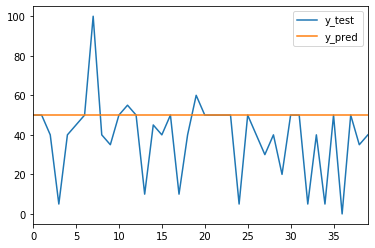

In [17]:
for _ in range(200):
    model.partial_fit(xTrain, yTrain.ravel())

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [18]:

import statsmodels.api as sm

In [19]:

olsmod = sm.OLS(yTrain, xTrain)
olsres = olsmod.fit()

In [20]:
olsres.summary()

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Fri, 18 Oct 2019   Prob (F-statistic):                nan
Time:                        15:00:25   Log-Likelihood:                 988.78
No. Observations:                  60   AIC:                            -1858.
Df Residuals:                       0   BIC:                            -1732.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -20.6229        inf         -0        nan         nan         nan
x2           563.9261        inf          0        nan         nan         nan
x3            -0.0403        inf         -0        nan         nan         nan
x4            40.3508        inf          0        nan         nan         nan
x5           161.4062        inf          0        nan         nan         nan
x6             0.0588        inf          0        nan         nan         nan
x7            18.4756        inf          0        nan         nan         nan
x8           110.8536        inf          0        nan         nan         nan
x9            34.0819        inf          0        nan         nan         nan
x10         -8.16e+04        inf         -0        nan         nan         nan
x11        -1.718e+05        inf         -0        nan         nan         nan
x12         -1.72e+05        inf         -0        nan         nan         nan
x13         4.254e+04        inf          0        nan         nan         nan
x14         2.126e+04        inf          0        nan         nan         nan
x15         4.804e+04        inf          0        nan         nan         nan
x16         4.252e+04        inf          0        nan         nan         nan
x17         4.259e+04        inf          0        nan         nan         nan
x18        -8.186e+04        inf         -0        nan         nan         nan
x19         4.309e+04        inf          0        nan         nan         nan
x20         1.027e+05        inf          0        nan         nan         nan
x21         1.541e+04        inf          0        nan         nan         nan
x22         4.164e+04        inf          0        nan         nan         nan
x23           -0.0502        inf         -0        nan         nan         nan
x24           -0.0433        inf         -0        nan         nan         nan
x25           -0.0963        inf         -0        nan         nan         nan
x26            0.1364        inf          0        nan         nan         nan
x27            6.1207        inf          0        nan         nan         nan
x28            7.5378        inf          0        nan         nan         nan
x29           -3.3498        inf         -0        nan         nan         nan
x30           -4.8592        inf         -0        nan         nan         nan
x31            8.5654        inf          0        nan         nan         nan
x32            2.8871        inf          0        nan         nan         nan
x33           11.0758        inf          0        nan         nan         nan
x34           -7.9381        inf         -0        nan         nan         nan
x35           -3.9398        inf         -0        nan         nan         nan
x36           -2.7271        inf         -0        nan         nan         nan
x3

In [21]:
yPred = olsres.predict(xTest)
avg_gain_ratio(yTest, yPred)

-0.0029543526648789786

In [25]:
df_full[["min_offer", "offer_final"]].describe()

,min_offer,offer_final
count,100.000000,100.000000
mean,40.900000,43.250000
std,18.151718,14.997895
min,0.000000,0.000000
25%,35.000000,40.000000
50%,45.000000,50.000000
75%,50.000000,50.000000
max,100.000000,100.000000


In [28]:
for v in df_full.offer_final.values:
    offer = np.ones(df_full.offer_final.shape)*v
    print(avg_gain_ratio(df_full.min_offer, offer))

0.8117266140292455
0.8117266140292455
0.11378947368421052
0.8117266140292455
0.7405539526263211
0.02
0.11378947368421052
0.8117266140292455
0.13114619883040934
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.14294956140350878
0.8117266140292455
0.3947992095623674
0.17341959064327483
0.10746783625730995
0.8117266140292455
0.11378947368421052
0.8117266140292455
0.8117266140292455
0.13114619883040934
0.10746783625730995
0.8117266140292455
0.8117266140292455
0.21103247702589806
0.21103247702589806
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.3947992095623674
0.8117266140292455
0.8117266140292455
0.4418992754321701
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.14294956140350878
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.8117266140292455
0.668270180112